# Distance metrics

References: López de Prado, Marcos. Machine Learning for Asset Managers. United States, Cambridge University Press, 2020.

## Correlation-based metric

Correlation is a measure of linear codependence. Can use correlation to find clusters of highly interrelated securities - however, correlation in itself is not a proper distance metric (although it is a similarity measure). 

The measure d(X,Y) = sqrt(1/2(1-corr(X,Y)) is a metric (particularly of for long-only portfolios)

The measure d(X,Y) = sqrt(1-abs(corr(X,Y)) is also a metric (particularly for long-short portfolios)

## Entropy-based metric

Correlation has 3 main caveats:

1. It quantifies the linear codependency between two random variables. It neglects non-linear relationships
2. Correlation is highly influenced by outliers
3. Its application beyond the multivariate Normal case is questionable - correlation is typically meaningless unless the two variables follow a bivariate Normal distribution.

For non-linear cases, the Normalised Variation of Information is a more appropriate distance metric (bounded between 0 and 1). The variation of information can be interpreted as the uncertainty we expect in one variable if we are told the value of another variable.

VI[X,Y] = H[X,Y] - I[X,Y] 

,where H[X,Y] and I[X,Y] is the joint entropy and mutual information of X and Y, respectively. The mutual information is defined as the decrease in uncertainty in X that results from knowing the value of Y. Mutual information is not a metric but is a similarity measure. **We can consider normalized mutual information as the information-theoretic analogue to linear algebra's correlation coefficient**.

Normalized mutual information (NMI) takes real values within the range [0,1], like the absolute value of the correlation coefficient. **Note that 1-NMI is a metric.**

In [3]:
import numpy as np, scipy.stats as ss
import pandas as pd
from sklearn.metrics import mutual_info_score
from numba import njit, prange
import time

# Function to calculate VI for discrete variables
def varInfoDisc(x,y,bins,norm=False):
    # variation of information
    cXY=np.histogram2d(x,y,bins)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=ss.entropy(np.histogram(x,bins)[0]) # marginal
    hY=ss.entropy(np.histogram(y,bins)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY #joint
        vXY/=hXY # normalised variation of information
    return vXY

# Functions to calculate VI for continuous variables
def numBins(nObs,corr=None):
    # Optimal number of bins for discretization
    if corr is None: #univariate case
        z=(8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b=round(z/6.+2./(3*z)+1./3)
    else: #bivariate case
        b=round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)
    return int(b)
                
def varInfoCts(x,y,norm=False):
    # variation of information
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
    hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY #joint
        vXY/=hXY # normalised variation of information
    return vXY
                

# Normalised mutual information (NMI)
'''
Note that I have changed the code for NMI to have max(hX,hY) instead of the one in the book i.e min(hX,hY)
This is because when using min(hX,hY), 1-NMI is NOT a metric
'''
def mutualInfo(x,y,norm=False):
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
    #bXY=numBins(x.shape[0],corr=None)
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    if norm:
        hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
        hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
        iXY/=max(hX,hY) #normalized mutual information
    return iXY 

# Function to calculate mutualInfo matrix similar to correlation matrix
def calcMutualInfoMatrix(data,norm=False):
    '''
    Input: np.ndarray with returns on columns i.e. each column is a separate stock
    Output: np.ndarray matrix of mutual information scores
    '''
    n=data.shape[1]
    rnge = np.arange(n)
    
    # initialize matrix with zeros
    mutualInfoMatrix = np.zeros((n, n))

    for ix in np.arange(n):
        for jx in np.arange(ix+1,n):
            mutualInfoMatrix[ix,jx] = mutualInfo(data[:,ix], data[:,jx],norm)
            
    return mutualInfoMatrix


df = pd.read_csv('log_returns.csv',skiprows=1,header=0,index_col=0)
print(mutualInfo(df.iloc[:,0],df.iloc[:,3],False))
print(ss.entropy(df.iloc[:,0])) 
df = df.to_numpy()
print(df.shape)
tic = time.perf_counter()
nmi = pd.DataFrame(calcMutualInfoMatrix(df,True))
toc = time.perf_counter()
print(f"Ran calc in {toc - tic:0.4f} seconds")

nmi.to_csv('nmi.csv')

0.7177277176519824
-inf
(36, 2854)
Ran calc in 4406.0510 seconds


# Clustering

## Base clustering

If we use k-means, there are 2 main drawbacks:
1. The algo requires the number of clusters K as an input which is not optimal a-priori
2. The initialization of k-means is random meaning results can be random too

The base clustering algorithm addresses these 2 concerns as follows:
1. Optimal number of clusters - use silhouette scores to assess quality of clusters (I've used this before where quality is the mean of the silhouette scores divided by the variance of the silhouette scores for a particular partition)
2. K-means initialization - attempt different initializations whereby we create 2 for loops

**RS edits: However, because we can implement K-means++ in sklearn, we can mitigate the random initialization of k-means. Therefore, only need one FOR loop that will test the number of clusters.**

## Higher-level clustering

This is a third modification on top of the base-clustering. Deals with clusters of inconsistent quality. Evaluate quality of each cluster k=1,...,K given the clustering quality scores obtained from the base clustering. We get the average quality and find the set of clusters below the average. If K1 is the number of 'poor quality' clusters then K1$\lt$K and if K1$\geq$2, the base clustering is re-run using a new reduced observations matrix that only has the elements in K1. This may result in new clusters within elements of K1. Then check quality scores again and see if average cluster quality improves. 

In [2]:
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

'''
Raj Shah: Adapted algorithm as we can use k-means++ to mitigate the random initialization of k-means. Therefore, only need
one FOR loop that will test the number of clusters.

n_init is Number of times the k-means algorithm will be run with different centroid seeds. 
The final results will be the best output of n_init consecutive runs in terms of inertia
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
'''

def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
    
    x,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series(dtype='float64')# observations matrix, convert correlations into a metric
    
    for i in range(2,maxNumClusters+1):
        kmeans_=KMeans(init='k-means++',n_clusters=i,n_init=n_init)# changed init to k-means++
        kmeans_=kmeans_.fit(x)
        silh_=silhouette_samples(x,kmeans_.labels_)
        stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
        if np.isnan(stat[1]) or stat[0]>stat[1]:
            silh,kmeans=silh_,kmeans_
    newIdx=np.argsort(kmeans.labels_)
    corr1=corr0.iloc[newIdx] #reorder rows
    corr1=corr1.iloc[:,newIdx] #reorder columns
    clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist()\
           for i in np.unique(kmeans.labels_)} #cluster members
    silh=pd.Series(silh,index=x.index)
    return corr1,clstrs,silh


def makeNewOutputs(corr0,clstrs,clstrs2):
    clstrsNew={}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    newIdx=[j for i in clstrsNew for j in clstrsNew[i]]
    corrNew=corr0.loc[newIdx,newIdx]
    x=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs=[x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(x,kmeans_labels),index=x.index)
    return corrNew,clstrsNew,silhNew


def clusterKMeansTop(corr0,maxNumClusters=None,n_init=10):
    if maxNumClusters==None:maxNumClusters=corr0.shape[1]-1
    corr1,clstrs,silh=clusterKMeansBase(corr0,maxNumClusters=min(maxNumClusters,corr0.shape[1]-1),n_init=n_init)
    clusterTstats={i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean=sum(clusterTstats.values())/len(clusterTstats)
    redoClusters=[i for i in clusterTstats.keys() if clusterTstats[i]<tStatMean]
    if len(redoClusters)<=1:
        return corr1,clstrs,silh
    else:
        keysRedo=[j for i in redoClusters for j in clstrs[i]]
        corrTmp=corr0.loc[keysRedo,keysRedo]
        tStatMean=np.mean([clusterTstats[i] for i in redoClusters])
        corr2,clstrs2,silh2=clusterKMeansBase(corrTmp,maxNumClusters=min(maxNumClusters,corrTmp.shape[1]-1),n_init=n_init)
    
    # Make new outputs if necessary
    corrNew,clstrsNew,silhNew=makeNewOutputs(corr0,{i:clstrs[i] for i in clstrs.keys() if i not in redoClusters},clstrs2)
    newTstatMean=np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
    if newTstatMean<=tStatMean:
        return corr1,clstrs,silh
    else:
        return corrNew,clstrsNew,silhNew
    

    
        

## Generation of random block correlation matrices and testing clustering algorithm

Create a NxN correlation matrix where intrablock correlation is high and across-block correlation is low. Subsequently shuffle the matrix to test the clustering algorithms to see if the blocks are recovered.

The example below shows that the original blocks/clusters are recovered

In [3]:
import numpy as np, pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
from ipynb.fs.defs.Covariance_Matrix_Denoising_and_Detoning import cov2corr

def getCovSub(nObs,nCols,sigma,random_state=None):
    #sub correl matrix
    rng=check_random_state(random_state)
    if nCols==1:return np.ones((1,1))
    ar0=rng.normal(size=(nObs,1))
    ar0=np.repeat(ar0,nCols,axis=1)
    ar0+=rng.normal(scale=sigma,size=ar0.shape)
    ar0=np.cov(ar0,rowvar=False)
    return ar0


def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,random_state=None):
    # Generate a random block correlation matrix
    rng=check_random_state(random_state)
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks),nBlocks-1,replace=False)
    parts.sort()
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)
    parts=np.append(parts[0],np.diff(parts))-1+minBlockSize
    cov=None
    for nCols_ in parts:
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)),nCols_,sigma,random_state=rng)
        if cov is None:cov=cov_.copy()
        else:cov=block_diag(cov,cov_)
    return cov

def randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1):
    # form block correlation matrix
    rng=check_random_state(random_state)
    
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,sigma=.5,random_state=rng)
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,sigma=1.,random_state=rng) #add noise
    cov0+=cov1
    corr0=cov2corr(cov0)
    corr0=pd.DataFrame(corr0)
    return corr0  


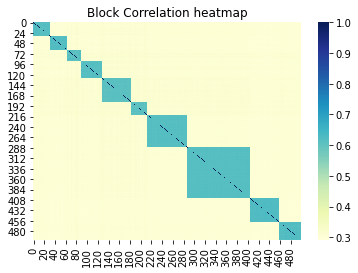

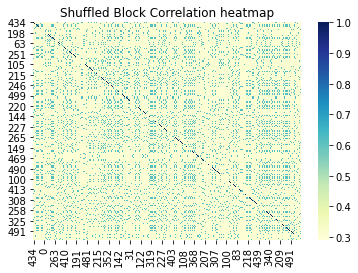

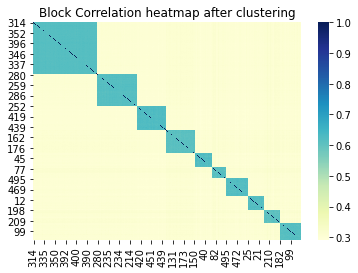

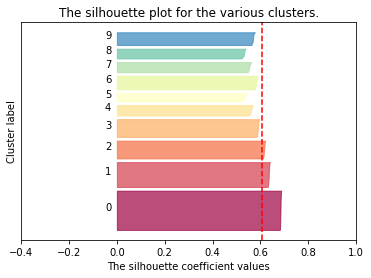

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

corr=randomBlockCorr(500,10,random_state=3,minBlockSize=25)
plt.figure()
ax = sns.heatmap(corr,cmap="YlGnBu")
ax.set_title('Block Correlation heatmap')


cols=corr.columns.tolist()
np.random.shuffle(cols)
corr0=corr[cols].loc[cols].copy(deep=True)
plt.figure()
ax2 = sns.heatmap(corr0,cmap="YlGnBu")
ax2.set_title('Shuffled Block Correlation heatmap')

corr1,clusters,silh=clusterKMeansTop(corr0,maxNumClusters=20,n_init=10)
plt.figure()
ax3 = sns.heatmap(corr1,cmap="YlGnBu")
ax3.set_title('Block Correlation heatmap after clustering')


def plotSilhouette(clusters,silh):
    
    k=len(clusters.keys()) #number of clusters
    s_score=np.mean(silh) #mean silhouette score
    
    fig, ax = plt.subplots()
    y_lower = 10

    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        idx=clusters[i]
        ith_cluster_silhouette_values = silh[idx]

        ith_cluster_silhouette_values_sorted=ith_cluster_silhouette_values.sort_values()

        #print(ith_cluster_silhouette_values_sorted)
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values_sorted,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=s_score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()
    
plotSilhouette(clusters,silh)

# Nested Clustering Optimization

In practice, mean-variance optimization (MVO) optimal solutions tend to be concentrated and unstable. One solution is to improve the numerical stability of the covariance matrix's inverse. Also, it turns out that signal contained in the covariance matrix can also be a source of instability. Therefore, need to address this source of instability to get better results.

The more the correlations deviate from zero, the bigger one eigenvalue becomes at the expense of another, causing the inverse covariance matrix explode. Generally, the instability caused by the covariance structure can be measured by the condition number of the covariance matrix i.e. the absolute value of the ratio between the maximal and minimal (by moduli) eigenvalues. 

When securities are highly correlated, the condition number is high. Unless $\rho \approx 0$, we expect an unstable solution to the convex optimization program. In reality $\rho \not\approx 0$ and weights are therefore unstable - this is Markovitz's curse. Therfore, even if the covariance matrix is denoised, the instability still remains.

## Signal as a source of covariance instability

Covariance instability associated with noise is regulated by the N/T ratio (where N is the number of stocks and T is the time period), because the lower bound of the Marchenko-Pastur (MP) distribution, $\lambda_\_$, gets smaller as N/T grows, while the upper bound, $\lambda_+$, increases as N/T grows. However, the source of instability is caused by the structure of the data; $\rho$ regulates the matrix's condition number, regardless and independently from N/T. **Signal-induced instability is structural and cannot be reduced by sampling more observations.** 

This is explained intuitively with the example below. We generate a block-diagonal matrix below composed of 2 equal-sized blocks, where the intrablock correlation is 0.5, and the outer-block correlation is zero. This block structure results in a condition number of 3. 

The condition number rises if:
1. We make one block bigger than the others
2. Increase the intra-block correlation

In both cases, one eigenvector explains more variance than the rest. E.g. if we increase the size of one block to 3 and reduce the size of the other to 1, the condition number becomes 4. If instead, the intrablock correlation is increased to 0.75, the condition number becomes 7.

A block-diagonal matrix of size 500x500 with 2 equal-sized blocks where the intrablock correlation is 0.5 has a condition number of 251, as a results of having 500 eigenvectors where most of the variance is explained by only 2. 

Bringing down the intrablock correlation in only one of the 2 blocks does not reduce the condition number - because the extreme eigenvalues are caused by the dominant block. So even though the high condition number may be cause by only one cluster, it impacts the entire correlation matrix. **The instability of Markovitz's solution can be traced back to a few dominant clusters within the correlation matrix.** We can contain that instability by optimizing the dominant clusters separately, hence preventing the instability spreading throughout the entire portfolio.




Condition number:  3.0
Condition number:  7.0
Condition number:  3.0


<AxesSubplot:>

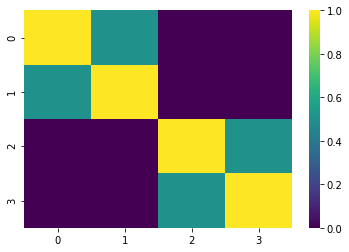

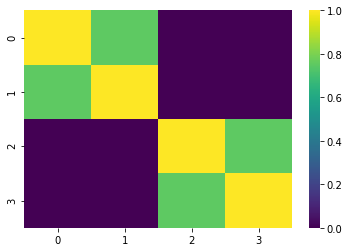

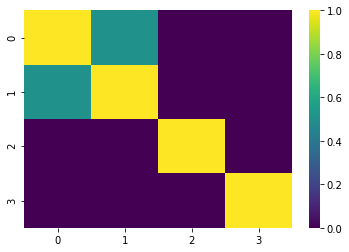

In [5]:
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np
from ipynb.fs.defs.Covariance_Matrix_Denoising_and_Detoning import formBlockMatrix

corr0=formBlockMatrix(2,2,.5)
eVal,eVec=np.linalg.eigh(corr0)
print("Condition number: ", max(eVal)/min(eVal))
plt.figure()
sns.heatmap(corr0,cmap='viridis')

corr0=formBlockMatrix(2,2,.75)
eVal,eVec=np.linalg.eigh(corr0)
print("Condition number: ", max(eVal)/min(eVal))
plt.figure()
sns.heatmap(corr0,cmap='viridis')

corr0=formBlockMatrix(1,2,.5)
corr1=formBlockMatrix(1,2,.0)
corr0=block_diag(corr0,corr1)
eVal,eVec=np.linalg.eigh(corr0)
print("Condition number: ", max(eVal)/min(eVal))
plt.figure()
sns.heatmap(corr0,cmap='viridis')


## Nested clustering optimization algorithm

The Nested Clustering Optimization (NCO) algorithm provides a strategy to tackle Markovitz's curse using the following pipeline:

Denoising/detoning **->** Correlation clustering **->** Compute optimal intracluster allocations using denoised covariance matrix **->** Derive reduced covariance matrix (i.e. correlations between clusters - by construction is should be close to a diagonal matrix and the optimization problem is close to the ideal Markovitz case) **->** Compute optimal intercluster allocations **->** Finally multiply intracluster weights with intercluster weights to get security allocations.


## Experimental results

This section shows the results of using traditional Markovitz MVO vs NCO for optimization using Monte Carlo simulation. In both minimum variance portfolios and maximum Sharpe ratio portfolios, NCO has the lowest error. Shrinkage does not actually help.

**Minimum variance portfolio RMSE vs true portfolio**

| | Markowitz | NCO |
| --- | --- | --- |
| Raw | 7.88E-03 | **4.18E-03** |
| Shrunk | 8.84E-03 | 6.72E-03 |

**Maximum Sharpe ratio portfolio RMSE vs true portfolio**

| | Markowitz | NCO |
| --- | --- | --- |
| Raw | 7.25E-03 | **3.14E-03** |
| Shrunk | 6.51E-03 | 5.75E-03 |



In [7]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

# Import functions from Covariance Matrix Denoising and Detoning
from ipynb.fs.defs.Covariance_Matrix_Denoising_and_Detoning import optPort
from ipynb.fs.defs.Covariance_Matrix_Denoising_and_Detoning import formBlockMatrix,formTrueMatrix
from ipynb.fs.defs.Covariance_Matrix_Denoising_and_Detoning import simCovMu

def optPort_nco(cov,mu=None,maxNumClusters=None):
    cov=pd.DataFrame(cov)
    if mu is not None:mu=pd.Series(mu[:,0])
    corr1=pd.DataFrame(cov2corr(cov))
    corr1,clstrs,_=clusterKMeansTop(corr1,maxNumClusters,n_init=10)
    wIntra=pd.DataFrame(0,index=cov.index,columns=clstrs.keys()) #empty dataframe to fill with intracluster weights
    
    for i in clstrs:
            cov_=cov.loc[clstrs[i],clstrs[i]].values #covariance matrix of cluster
        if mu is None:mu_=None
        else: mu_=mu.loc[clstrs[i]].values.reshape(-1,1)
        wIntra.loc[clstrs[i],i]=optPort(cov_,mu_).flatten() #optimize intra cluster weights and add to dataframe
    cov_=wIntra.T.dot(np.dot(cov,wIntra)) # reduce covariance matrix
    mu_=(None if mu is None else wIntra.T.dot(mu))
    wInter=pd.Series(optPort(cov_,mu_).flatten(),index=cov_.index)  #calculate inter cluster weights  
    nco=wIntra.mul(wInter,axis=1).sum(axis=1).values.reshape(-1,1) # multiply intracluster weights with intercluster weights
    return nco

nBlocks,bSize,bCorr=10,5,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)
#sns.heatmap(cov0, cmap='viridis')

# Simulations for Minimum Variance portfolios
nObs,nSims,shrink,minVarPortf=1000,1000,False,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort_nco(cov1,mu1,int(cov1.shape[0]/2)).flatten()

w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio/Maximum Sharpe Ratio portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation
rmse=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("MINIMUM VARIANCE PORTFOLIO - SIMULATION RESULTS")
print("Root mean squared error of simulations vs true portfolio")
print("RMSE - Markowitz, not shrunk: ",rmse)
print("RMSE - NCO, not shrunk: ",rmse_d)


nObs,nSims,shrink,minVarPortf=1000,1000,True,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort_nco(cov1,mu1,int(cov1.shape[0]/2)).flatten()

w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio/Maximum Sharpe Ratio portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation
rmse=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("MINIMUM VARIANCE PORTFOLIO - SIMULATION RESULTS")
print("Root mean squared error of simulations vs true portfolio")
print("RMSE - Markowitz, shrunk: ",rmse)
print("RMSE - NCO, shrunk: ",rmse_d)
    
    
# Simulations for MAx Sharp ratio portfolios
nObs,nSims,shrink,minVarPortf=1000,1000,False,False
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort_nco(cov1,mu1,int(cov1.shape[0]/2)).flatten()

w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio/Maximum Sharpe Ratio portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation
rmse=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("MAX SHARPE RATIO PORTFOLIO - SIMULATION RESULTS")
print("Root mean squared error of simulations vs true portfolio")
print("RMSE - Markowitz, not shrunk: ",rmse)
print("RMSE - NCO, not shrunk: ",rmse_d)


nObs,nSims,shrink,minVarPortf=1000,1000,True,False
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort_nco(cov1,mu1,int(cov1.shape[0]/2)).flatten()

w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio/Maximum Sharpe Ratio portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation
rmse=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("MAX SHARPE RATIO PORTFOLIO - SIMULATION RESULTS")
print("Root mean squared error of simulations vs true portfolio")
print("RMSE - Markowitz, shrunk: ",rmse)
print("RMSE - NCO, shrunk: ",rmse_d)
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 24)